<a href="https://colab.research.google.com/github/mifm/examples/blob/master/topfarm_IEA_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
!pip install topfarm

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


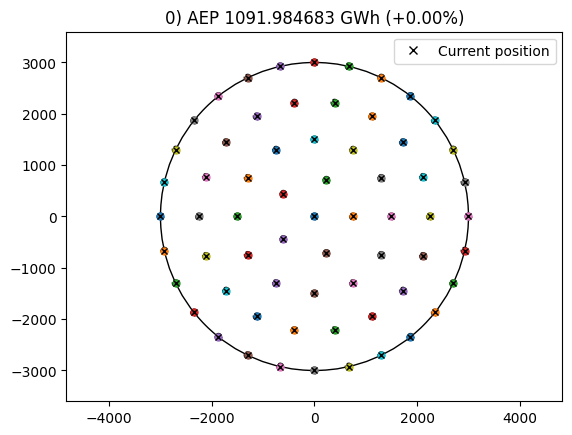

Iteration limit reached    (Exit mode 9)
            Current function value: -1248.9542123273068
            Iterations: 100
            Function evaluations: 181
            Gradient evaluations: 100
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	673.082s
INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


[-1248.9542123273068, {'x': array([   50.8024229 ,   879.29977066,   349.12801179,  -538.719038  ,
        -615.9026982 ,   208.89319325,  1487.83738193,  1310.86743244,
         704.95791327,    88.5722407 ,  -728.07489905, -1355.35314654,
       -1477.21247477, -1294.32157873,  -761.43621705,   -74.45465912,
         617.77512816,  1319.26950978,  2336.95039526,  2146.29014682,
        1762.55081082,  1191.40934911,   473.36981464,  -530.75841237,
       -1179.50620651, -1799.9432999 , -2216.85359462, -2281.74546838,
       -2133.44152423, -1611.17280017, -1210.45479004,  -510.09500998,
         527.52684137,  1227.20682164,  1734.7772    ,  2148.86907649,
        2980.87102584,  2926.92501203,  2344.61434046,  2349.74743829,
        1701.99570187,  1312.94463694,   643.39518424,   -38.23540257,
        -648.71730304, -1340.40114531, -1814.31390115, -2385.76414889,
       -2720.61746839, -2872.70870981, -2984.20168759, -2875.68470302,
       -2781.09873074, -2281.23195114, -1820.2785

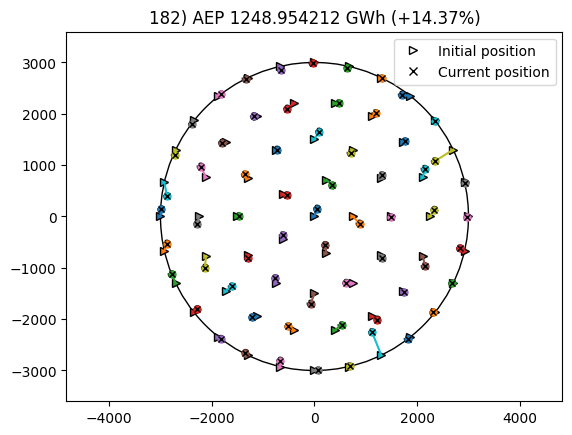

In [6]:
import py_wake
import topfarm
import numpy as np
from numpy import array as npa
import matplotlib.pyplot as plt

from py_wake.deficit_models import *
from py_wake.deficit_models.deficit_model import *
from py_wake.deficit_models.gaussian import *
from py_wake.wind_farm_models import *
from py_wake.rotor_avg_models import *
from py_wake.superposition_models import *
from py_wake.deflection_models import *
from py_wake.turbulence_models import *
from py_wake.ground_models import *
from py_wake.deficit_models.utils import *


from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site

from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot, XYPlotComp
from topfarm import easy_drivers
from topfarm.easy_drivers import EasyScipyOptimizeDriver, EasySimpleGADriver

from py_wake.examples.data.iea37 import iea37_path
from py_wake.examples.data.iea37.iea37_reader import read_iea37_windturbine
from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

n_wt = 64
n_wd = 16

def get_IEA37_initial(n_wt):
    site = IEA37Site(n_wt)
    return site.initial_position

site = IEA37Site(n_wt)
x, y = get_IEA37_initial(n_wt).T * 0.99999
wind_turbines = IEA37_WindTurbines()
wd = np.linspace(0.,360.,n_wd, endpoint=False)
wfmodel = PropagateDownwind(
    site,
    wind_turbines,
    wake_deficitModel=BlondelSuperGaussianDeficit2023(),
    superpositionModel=LinearSum(),
    deflectionModel=None,
    turbulenceModel=CrespoHernandez(),
    rotorAvgModel=None)
driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=100, tol=1e-6 ,disp=True)

diam = read_iea37_windturbine(iea37_path + 'iea37-335mw.yaml')[2]
spac_constraint = SpacingConstraint(1 * diam)
bound_radius = 3000
bound_constraint = CircleBoundaryConstraint((0, 0), bound_radius)

constraints = [SpacingConstraint(min_spacing=diam), bound_constraint]
wd = npa(range(16)) * 22.5

def aep_func(x,y,wd=wd):
    sim_res = wfmodel(x,y, wd=wd,ws=9.8)
    aep = sim_res.aep().sum()
    return aep

cost_component = CostModelComponent(input_keys=['x','y'],
                              n_wt=n_wt,
                              cost_function=aep_func,
                              output_keys=[('AEP', 0)],
                              output_unit="GWh",
                              objective=True,
                              maximize=True
                             )
Layout_optimisation_problem = TopFarmProblem(design_vars={'x': x, 'y': y},
                          n_wt=n_wt,
                          cost_comp=cost_component,
                          constraints=constraints,
                          driver=driver,
                          plot_comp=XYPlotComp()
                        )
_, state, recorder = Layout_optimisation_problem.optimize(disp=True)
[aep, new_states] = Layout_optimisation_problem.evaluate()
print([aep,new_states])

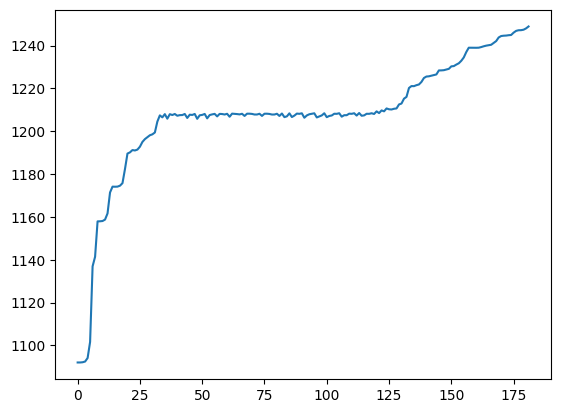

In [7]:
plt.figure()
plt.plot(recorder['AEP'])